# Airsoft Telemetry Data Analysis

This notebook demonstrates how to read and display sample telemetry data from the docs/analysis folder.

In [28]:
# Import Required Libraries
import os
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Read Sample Data File
sample_path = './data/sample-1.csv'  # Adjusted path to match the context
df = pd.read_csv(sample_path)

In [43]:
# Show dataframe columns to check for speed
print(df.columns.tolist())

['ID', 'Game Session ID', 'Player ID', 'Event Type', 'Timestamp', 'Date Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth']


In [18]:
df = df.iloc[1:].copy()
df.at[df.index[0], 'Event Type'] = 'START'

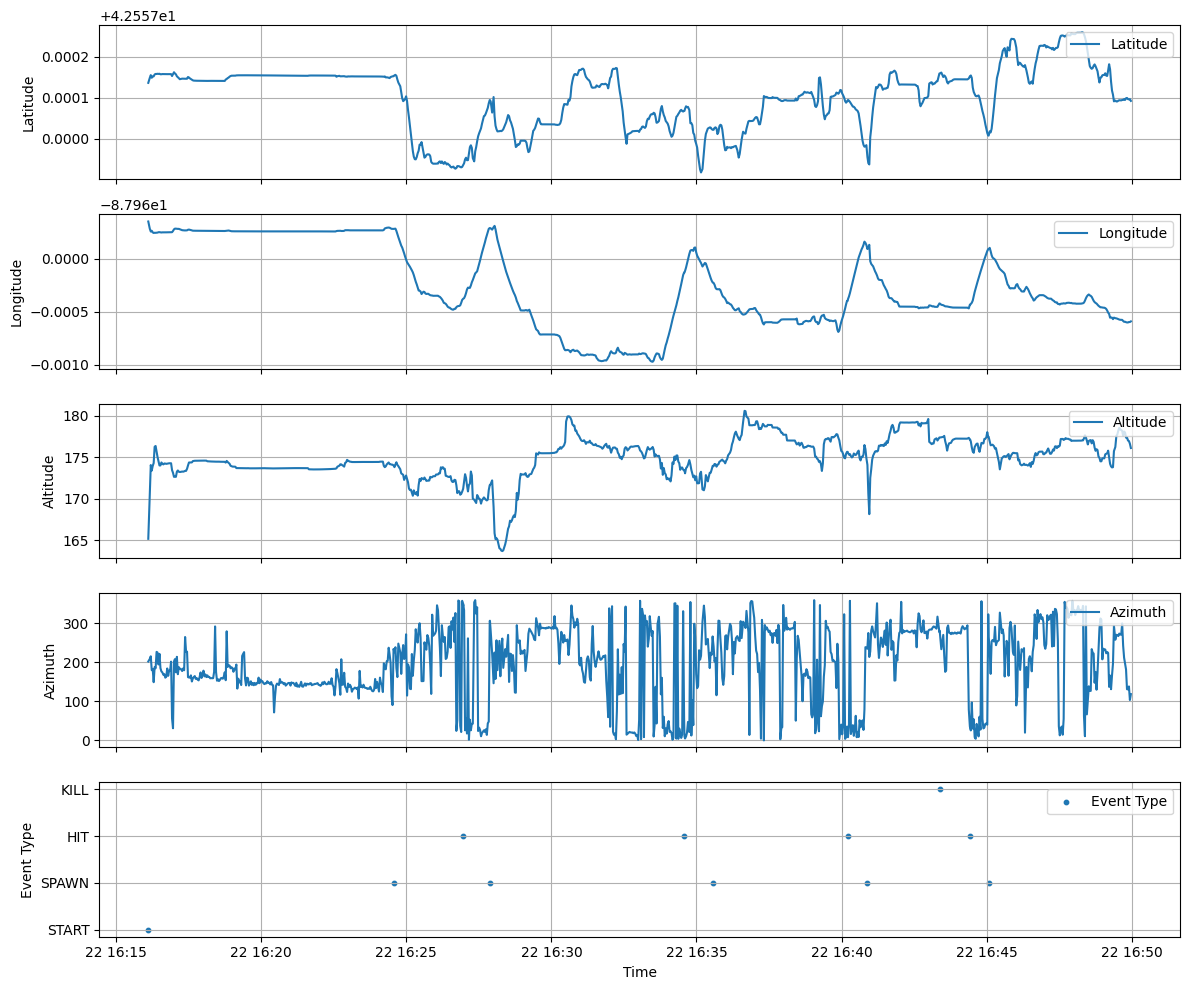

In [25]:
# Remove 'Location' event types from the Event Type chart
import matplotlib.pyplot as plt

metrics = ['Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Event Type']
time = pd.to_datetime(df['Date Time'])

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 10), sharex=True)
for i, metric in enumerate(metrics):
    if metric == 'Event Type':
        mask = df[metric] != 'LOCATION'
        axes[i].scatter(time[mask], df[metric][mask], label=metric, marker='o', s=10)
    else:
        axes[i].plot(time, df[metric], label=metric)
    axes[i].set_ylabel(metric)
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()


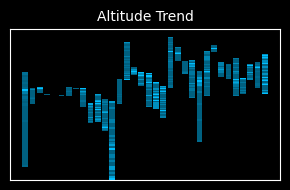

In [42]:
# Group altitude data by 1-minute intervals and plot min/max as bars with vertical brightness based on density (dark mode)

# Ensure 'Date Time' is datetime type
df['Date Time'] = pd.to_datetime(df['Date Time'])

interval = '1T'  # 1-minute intervals
grouped = df.groupby(pd.Grouper(key='Date Time', freq=interval))

alt_min = grouped['Altitude'].min()
alt_max = grouped['Altitude'].max()

plt.style.use('dark_background')
plt.figure(figsize=(3, 2), dpi=100)

num_bins = 40  # Number of vertical bins per bar

for idx, (interval_time) in enumerate(alt_min.index):
    # Get all altitude values in this interval
    altitudes = grouped.get_group(interval_time)['Altitude'] if interval_time in grouped.groups else []
    if len(altitudes) == 0:
        continue
    amin, amax = alt_min[interval_time], alt_max[interval_time]
    bins = np.linspace(amin, amax, num_bins+1)
    counts, _ = np.histogram(altitudes, bins=bins)
    max_count = counts.max() if counts.max() > 0 else 1
    for b in range(num_bins):
        bin_bottom = bins[b]
        bin_top = bins[b+1]
        density = counts[b] / max_count
        # Map density to brightness (0.5 to 1.0 for visibility)
        brightness = 0.5 + 0.5 * density
        color = (0, 191/255 * brightness, 1 * brightness)  # scale blue channel
        plt.bar(idx, bin_top-bin_bottom, bottom=bin_bottom, width=0.8, color=color, edgecolor=None)

plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('')  # Remove x-axis label
plt.ylabel('')  # Remove y-axis label
plt.title('Altitude Trend', fontsize=10)   # Add chart title with smaller font
plt.tight_layout()
plt.show()

In [49]:
import google.generativeai as genai

import os

api_key = os.getenv("GEMINI_API_KEY")

# Prepare the prompt with all telemetry data

prompt = (
    "Analyze the following telemetry data from an airsoft game. "
    "Provide insights such as terrain changes, possible player movement patterns, and any anomalies.\n\n"
    "Telemetry Data:\n"
    )

for idx, row in df.iterrows():
    row_str = ', '.join([f"{col}: {row[col]}" for col in df.columns])
    prompt += f"{row['Date Time']}: {row_str}\n"

# Call Gemini API

genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-2.5-flash')

response = model.generate_content(prompt)

# Display Gemini's insights

print(response.text)

KeyboardInterrupt: 